# Python notebook for characterizing properties of the DynamicViz variance score (Figure 2)

https://doi.org/10.1101/2022.05.27.493785

In [1]:
import sys
import scanpy as sc
import scvelo as scv
import warnings
warnings.simplefilter("ignore", category=UserWarning)
warnings.simplefilter("ignore", category=FutureWarning)
warnings.simplefilter("ignore", category=DeprecationWarning)
import anndata as ad
import numpy as np
import pandas as pd
import seaborn as sns#; sns.set()
#sns.set(font_scale = 1.5)
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter1d
from scipy.stats import pearsonr, spearmanr
from scipy.sparse import save_npz, load_npz
from sklearn.decomposition import PCA
from statannot import add_stat_annotation
import os

from dynamicviz.dynamicviz import boot, viz, score, utils

In [2]:
def sample_gaussian_mixture(n,p,magnitude=1,k=5):
    '''
    Generates a n x p array of n observations with p features from a mixture of p-dimensional unit variance Gaussians
        No covariance between Gaussians
        
    magnitude corresponding to mean (larger means further apart and better separated)
    k = number of Gaussians
    '''
    if k > p:
        raise Exception("k cannot be larger than p")
    
    X = np.zeros((n,p))
    y = np.zeros(n)
    for i in range(n):
        ri = np.random.randint(k)
        means = np.zeros(p)
        means[ri] = magnitude
        X[i,:] = np.random.multivariate_normal(means, np.identity(p), 1)
        y[i] = ri

    return (X, y)

# Figure 2B: Empirical validation of bootstrap theory

For data generation, see "run_bootstrap_theory_validation.slurm" and "bootstrap_theory_validation.py"

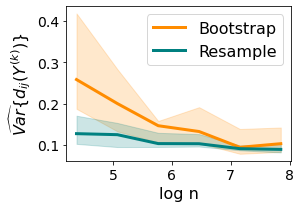

In [5]:
df = pd.read_csv("scg_results/umap_N80_2560_results.csv")

df = df[df["n"] > 0].reset_index()
df['log n'] = np.log(df['n'].values)

df = pd.melt(df, id_vars=["index", "log n", "n"],
             value_vars=["Bootstrap sample distance variance", "Real sample distance variance"],
       value_name="Variance", var_name="Quantity")
plt.figure(figsize=(4.5,3))
sns.lineplot(data=df, x="log n", y="Variance", hue="Quantity", estimator=np.median, linewidth=3, palette=["darkorange", "teal"])
plt.legend(labels=['Bootstrap', 'Resample'], fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("$\widehat{Var} \{ d_{ij} (Y^{(k)}) \}$", fontsize=16)
plt.xlabel("log n", fontsize=16)
plt.tight_layout()
plt.savefig("figures/Figure2/umap_N80_2560_varyN.png", dpi=500, bbox_inches='tight')
plt.show()

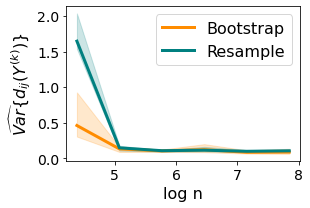

In [6]:
# ED Figure 4B
df = pd.read_csv("scg_results/tsne_N80_2560_results.csv")

df = df[df["n"] > 0].reset_index()
df['log n'] = np.log(df['n'].values)

df = pd.melt(df, id_vars=["index", "log n", "n"],
             value_vars=["Bootstrap sample distance variance", "Real sample distance variance"],
       value_name="Variance", var_name="Quantity")
plt.figure(figsize=(4.5,3))
sns.lineplot(data=df, x="log n", y="Variance", hue="Quantity", estimator=np.median, linewidth=3, palette=["darkorange", "teal"])
plt.legend(labels=['Bootstrap', 'Resample'], fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("$\widehat{Var} \{ d_{ij} (Y^{(k)}) \}$", fontsize=16)
plt.xlabel("log n", fontsize=16)
plt.tight_layout()
plt.savefig("figures/Figure2/tsne_N80_2560_results_varyN.png", dpi=500, bbox_inches='tight')
plt.show()
plt.show()

## Figure 2C: Validation of bootstrap as $B \rightarrow \infty$

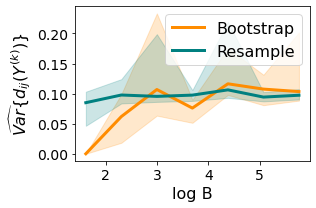

In [9]:
df = pd.read_csv("scg_results/umap_B5_320_results_.csv")

bootstraps = [5]*20+[10]*20+[20]*20+[40]*20+[80]*20+[160]*20+[320]*20
df['B'] = bootstraps

df = df[df["B"] > 0].reset_index()
df['log B'] = np.log(df['B'].values)

df = pd.melt(df, id_vars=["index", "log B", "B"],
             value_vars=["Bootstrap sample distance variance", "Real sample distance variance"],
       value_name="Variance", var_name="Quantity")
plt.figure(figsize=(4.5,3))
sns.lineplot(data=df, x="log B", y="Variance", hue="Quantity", estimator=np.median, linewidth=3, palette=["darkorange", "teal"])
plt.legend(labels=['Bootstrap', 'Resample'], fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("$\widehat{Var} \{ d_{ij} (Y^{(k)}) \}$", fontsize=16)
plt.xlabel("log B", fontsize=16)
plt.tight_layout()
plt.savefig("figures/Figure2/umap_B5_320_results_varyB.png", dpi=500, bbox_inches='tight')

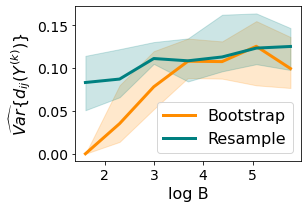

In [10]:
# ED Figure 4C
df = pd.read_csv("scg_results/tsne_B5_320_results_.csv")

bootstraps = [5]*20+[10]*20+[20]*20+[40]*20+[80]*20+[160]*20+[320]*20
df['B'] = bootstraps

df = df[df["B"] > 0].reset_index()
df['log B'] = np.log(df['B'].values)

df = pd.melt(df, id_vars=["index", "log B", "B"],
             value_vars=["Bootstrap sample distance variance", "Real sample distance variance"],
       value_name="Variance", var_name="Quantity")
plt.figure(figsize=(4.5,3))
sns.lineplot(data=df, x="log B", y="Variance", hue="Quantity", estimator=np.median, linewidth=3, palette=["darkorange", "teal"])
plt.legend(labels=['Bootstrap', 'Resample'], fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("$\widehat{Var} \{ d_{ij} (Y^{(k)}) \}$", fontsize=16)
plt.xlabel("log B", fontsize=16)
plt.tight_layout()
plt.savefig("figures/Figure2/tsne_B5_320_results_varyB.png", dpi=500, bbox_inches='tight')

## ED Figure 4A: Validation of bootstrap visualizations (properties of visualizations)

In [44]:
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score, silhouette_score

n = 500
p = 100
nboots = 100

In [8]:
# generate 100 bootstraps of synthetic data (do 10 times for robustness)

for method in ['umap', 'tsne']:
    for iid in range(10):
        savename = 'outputs/validation/SyntheticMag2k5_n'+str(n)+'_p'+str(p)+'_B'+str(nboots)+'_'+method+'_'+str(iid)
        X, y = sample_gaussian_mixture(n,p,magnitude=4,k=5)
        Y = pd.DataFrame(y, columns=['label'])
        out = boot.generate(X, Y=Y, method=method, B=nboots, use_n_pcs=False, num_jobs=4,
                        save=savename+".csv", random_seed=452, sigma_noise=1e-2)

100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:50<00:00,  1.99it/s]


In [9]:
# generate 100 real samples of synthetic data

for method in ['umap', 'tsne']:
    
    X, y = sample_gaussian_mixture(n,p,magnitude=4,k=5)
    
    # process results into dataframe
    output = pd.DataFrame() # init df to be merged onto

    # DR on original dataset
    original_embedding = boot.dimensionality_reduction(X, method) 

    # add basic info
    output["x1"] = original_embedding[:,0]
    output["x2"] = original_embedding[:,1]
    output["original_index"] = np.arange(len(original_embedding[:,0]))
    output["bootstrap_number"] = -1
    output["label"] = y
    
    # iterate
    for b in range(nboots):
        X, y = sample_gaussian_mixture(n,p,magnitude=2,k=5)
        emb = boot.dimensionality_reduction(X, method)

        new_df = pd.DataFrame() # new df to merge onto original df

        # add basic info
        new_df["x1"] = emb[:,0]
        new_df["x2"] = emb[:,1]
        new_df["original_index"] = np.arange(len(emb[:,0]))
        new_df["bootstrap_number"] = b
        new_df["label"] = y

        # merge to original dataframe
        output = pd.concat([output, new_df], axis=0)

    # save output
    savename = 'outputs/validation/SyntheticMag2k5_n'+str(n)+'_p'+str(p)+'_REAL'+str(nboots)+'_'+method
    output.to_csv(savename+'.csv', index=False)

In [45]:
# compute and compare statistics of visualizations

method = 'tsne'

savename = 'outputs/validation/SyntheticMag2k5_n'+str(n)+'_p'+str(p)+'_REAL'+str(nboots)+'_'+method
output = pd.read_csv(savename+'.csv')

#-----------------------------------------------------------

bootstrap_results = {'CH':[], 'DB':[], 'Silhouette':[]}
real_results = {'CH':[], 'DB':[], 'Silhouette':[]}

# compute stats for bootstraps
for i in range(10):
    savename = 'outputs/validation/SyntheticMag2k5_n'+str(n)+'_p'+str(p)+'_B'+str(nboots)+'_'+method+'_'+str(i)+'.csv'
    out = pd.read_csv(savename)
    CH_bootstrap_results = []
    DB_bootstrap_results = []
    S_bootstrap_results = []
    for b in np.unique(out['bootstrap_number']):
        X = np.vstack((out[out['bootstrap_number']==b]['x1'].values, out[out['bootstrap_number']==b]['x2'].values)).T
        y = out[out['bootstrap_number']==b]['label'].values
        # statistics
        CH_bootstrap_results.append(calinski_harabasz_score(X,y))
        DB_bootstrap_results.append(davies_bouldin_score(X,y))
        S_bootstrap_results.append(silhouette_score(X,y))
    # add to dict
    bootstrap_results['CH'].append(CH_bootstrap_results)
    bootstrap_results['DB'].append(DB_bootstrap_results)
    bootstrap_results['Silhouette'].append(S_bootstrap_results)
    
# compute stats for real samples
savename = 'outputs/validation/SyntheticMag2k5_n'+str(n)+'_p'+str(p)+'_REAL'+str(nboots)+'_'+method+'.csv'
out = pd.read_csv(savename)
for b in np.unique(out['bootstrap_number']):
    X = np.vstack((out[out['bootstrap_number']==b]['x1'].values, out[out['bootstrap_number']==b]['x2'].values)).T
    y = out[out['bootstrap_number']==b]['label'].values
    # compute stats
    real_results['CH'].append(calinski_harabasz_score(X,y))
    real_results['DB'].append(davies_bouldin_score(X,y))
    real_results['Silhouette'].append(silhouette_score(X,y))

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Using zero_method  wilcox
Resample v.s. Bootstrap 1: Wilcoxon test (paired samples) with Bonferroni correction, P_val=1.000e+00 stat=2.391e+03
Using zero_method  wilcox
Resample v.s. Bootstrap 2: Wilcoxon test (paired samples) with Bonferroni correction, P_val=1.000e+00 stat=2.571e+03
Using zero_method  wilcox
Resample v.s. Bootstrap 3: Wilcoxon test (paired samples) with Bonferroni correction, P_val=1.000e+00 stat=2.317e+03


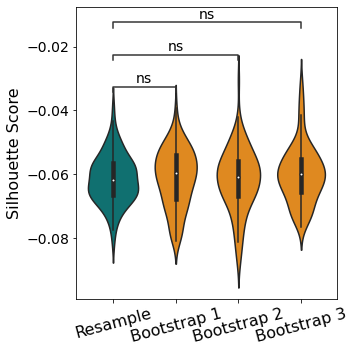

In [48]:
# Silhuoette score plot
key = 'Silhouette'

# resample stats
real_stats = real_results[key]
df = pd.DataFrame()
df[key] = real_stats
df['label'] = 'Resample'

# get some representative bootstraps
for idx, i in enumerate([2,4,5]):
    all_boot_stats = np.array(bootstrap_results[key][i])
    df2 = pd.DataFrame()
    df2[key] = all_boot_stats
    df2['label'] = 'Bootstrap '+str(idx+1)
    df = pd.concat((df,df2))

# make plot
plt.figure(figsize=(5,5))
ax = sns.violinplot(x='label', y=key, data=df, palette=['teal','darkorange','darkorange','darkorange'])
add_stat_annotation(ax, x="label", y=key, data=df,
                    box_pairs=[('Resample', 'Bootstrap 1'),('Resample', 'Bootstrap 2'),('Resample', 'Bootstrap 3')],
                    test='Mann-Whitney', text_format='star', loc='inside', verbose=2, fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 15)
ax.set_ylabel("Silhouette Score", fontsize=16)
ax.set_xlabel("")
plt.xticks(fontsize=16)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig("figures/Figure2/bootstrap_validation_silhouette_score.png", dpi=500, bbox_inches='tight')
plt.show()

## Figure 2D: UMAP/t-SNE/PCA plots of original data

In [43]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

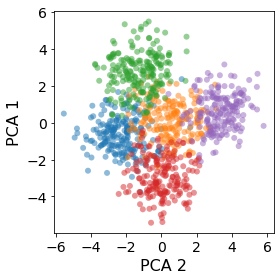

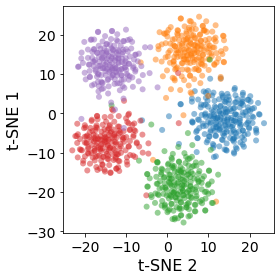

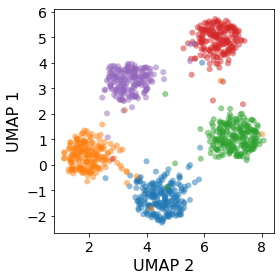

In [48]:
# mixture of 5 Gaussians (p=50, n=1000)
X, y = sample_gaussian_mixture(1000,50,magnitude=4,k=5)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

red = umap.UMAP(n_components=2)
X_umap = red.fit_transform(X)


############################################
plt.figure(figsize=(4,4))
for lab in np.unique(y):
    plt.scatter(X_pca[y==lab,0], X_pca[y==lab,1], label=str(lab), edgecolors='none', alpha=0.5)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("PCA 1", fontsize=16)
plt.xlabel("PCA 2", fontsize=16)
#leg = plt.legend(fontsize=14, loc='center left', bbox_to_anchor=(1, 0.5))
#for lh in leg.legendHandles: 
#    lh.set_alpha(1)
plt.tight_layout()
plt.savefig("figures/Figure2/gaussian_original_pca.png", dpi=500, bbox_inches='tight')
plt.show()

plt.figure(figsize=(4,4))
for lab in np.unique(y):
    plt.scatter(X_tsne[y==lab,0], X_tsne[y==lab,1], label=str(lab), edgecolors='none', alpha=0.5)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("t-SNE 1", fontsize=16)
plt.xlabel("t-SNE 2", fontsize=16)
#leg = plt.legend(fontsize=14, loc='center left', bbox_to_anchor=(1, 0.5))
#for lh in leg.legendHandles: 
#    lh.set_alpha(1)
plt.tight_layout()
plt.savefig("figures/Figure2/gaussian_original_tsne.png", dpi=500, bbox_inches='tight')
plt.show()

plt.figure(figsize=(4,4))
for lab in np.unique(y):
    plt.scatter(X_umap[y==lab,0], X_umap[y==lab,1], label=str(lab), edgecolors='none', alpha=0.5)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("UMAP 1", fontsize=16)
plt.xlabel("UMAP 2", fontsize=16)
#leg = plt.legend(fontsize=14, loc='center left', bbox_to_anchor=(1, 0.5))
#for lh in leg.legendHandles: 
#    lh.set_alpha(1)
plt.tight_layout()
plt.savefig("figures/Figure2/gaussian_original_umap.png", dpi=500, bbox_inches='tight')
plt.show()

### ED Figure 4E

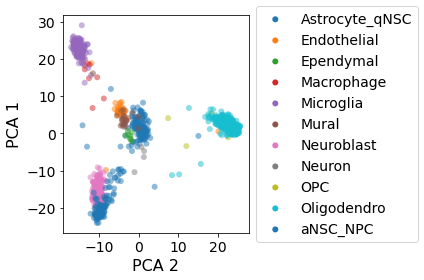

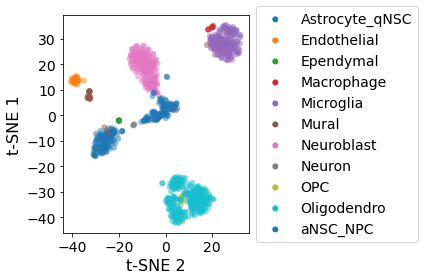

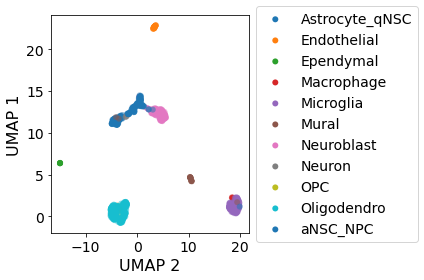

In [50]:
# subventricular zone (SVZ) n=1000 data
SVZ_X = pd.read_csv("sc_data/mouse_svz_aging_clock/svz_data.csv")
SVZ_X = SVZ_X.values
SVZ_X = SVZ_X/SVZ_X.sum(axis=1)[:,np.newaxis] # row normalize
SVZ_X = np.log1p(SVZ_X*10000) # scale up and take log1p
SVZ_y = np.genfromtxt("SVZ_y.txt", dtype=str)

pca50 = PCA(n_components=50)
X_top50pc = pca50.fit_transform(SVZ_X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(SVZ_X)

tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X_top50pc)

red = umap.UMAP(n_components=2)
X_umap = red.fit_transform(X_top50pc)


############################################
plt.figure(figsize=(6,4))
for lab in np.unique(SVZ_y):
    plt.scatter(X_pca[SVZ_y==lab,0], X_pca[SVZ_y==lab,1], label=str(lab), edgecolors='none', alpha=0.5)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("PCA 1", fontsize=16)
plt.xlabel("PCA 2", fontsize=16)
leg = plt.legend(fontsize=14, loc='center left', bbox_to_anchor=(1, 0.5))
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.tight_layout()
plt.savefig("figures/Figure2/svz_original_pca.png", dpi=500, bbox_inches='tight')
plt.show()

plt.figure(figsize=(6,4))
for lab in np.unique(SVZ_y):
    plt.scatter(X_tsne[SVZ_y==lab,0], X_tsne[SVZ_y==lab,1], label=str(lab), edgecolors='none', alpha=0.5)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("t-SNE 1", fontsize=16)
plt.xlabel("t-SNE 2", fontsize=16)
leg = plt.legend(fontsize=14, loc='center left', bbox_to_anchor=(1, 0.5))
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.tight_layout()
plt.savefig("figures/Figure2/svz_original_tsne.png", dpi=500, bbox_inches='tight')
plt.show()

plt.figure(figsize=(6,4))
for lab in np.unique(SVZ_y):
    plt.scatter(X_umap[SVZ_y==lab,0], X_umap[SVZ_y==lab,1], label=str(lab), edgecolors='none', alpha=0.5)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("UMAP 1", fontsize=16)
plt.xlabel("UMAP 2", fontsize=16)
leg = plt.legend(fontsize=14, loc='center left', bbox_to_anchor=(1, 0.5))
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.tight_layout()
plt.savefig("figures/Figure2/svz_original_umap.png", dpi=500, bbox_inches='tight')
plt.show()

### ED Figure 4G

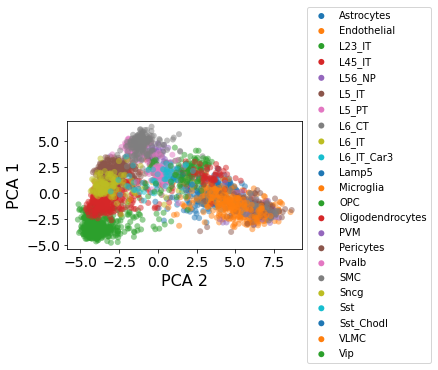

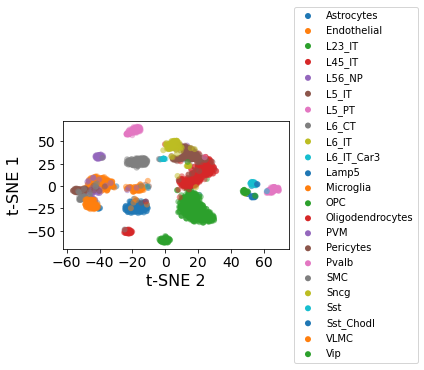

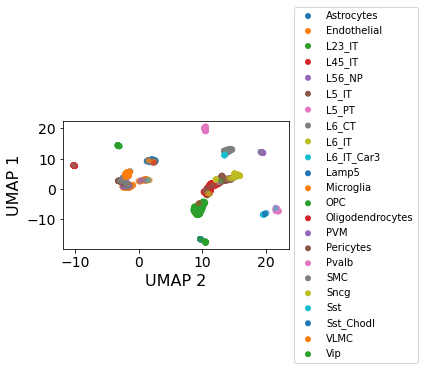

In [60]:
# merfish data (a representative replicate)
adata = sc.read_h5ad("sc_data/mouse_merfish_MOp/counts.h5ad")
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
merfish_metadata = pd.read_csv("sc_data/mouse_merfish_MOp/cell_metadata.csv")
adata.obs = merfish_metadata

adata_sub = adata.copy()[adata.obs['sample_id']=='dataset1_sample1']
sc.pp.subsample(adata_sub, n_obs=3000)
mer_X = adata_sub.X
mer_y = adata_sub.obs["subclass"].values


pca50 = PCA(n_components=50)
X_top50pc = pca50.fit_transform(mer_X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(mer_X)

tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X_top50pc)

red = umap.UMAP(n_components=2)
X_umap = red.fit_transform(X_top50pc)



############################################
plt.figure(figsize=(6,4))
for lab in np.unique(mer_y):
    plt.scatter(X_pca[mer_y==lab,0], X_pca[mer_y==lab,1], label=str(lab), edgecolors='none', alpha=0.5)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("PCA 1", fontsize=16)
plt.xlabel("PCA 2", fontsize=16)
leg = plt.legend(fontsize=10, loc='center left', bbox_to_anchor=(1, 0.5))
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.tight_layout()
plt.savefig("figures/Figure2/merfish_original_pca.png", dpi=500, bbox_inches='tight')
plt.show()

plt.figure(figsize=(6,4))
for lab in np.unique(mer_y):
    plt.scatter(X_tsne[mer_y==lab,0], X_tsne[mer_y==lab,1], label=str(lab), edgecolors='none', alpha=0.5)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("t-SNE 1", fontsize=16)
plt.xlabel("t-SNE 2", fontsize=16)
leg = plt.legend(fontsize=10, loc='center left', bbox_to_anchor=(1, 0.5))
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.tight_layout()
plt.savefig("figures/Figure2/merfish_original_tsne.png", dpi=500, bbox_inches='tight')
plt.show()

plt.figure(figsize=(6,4))
for lab in np.unique(mer_y):
    plt.scatter(X_umap[mer_y==lab,0], X_umap[mer_y==lab,1], label=str(lab), edgecolors='none', alpha=0.5)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("UMAP 1", fontsize=16)
plt.xlabel("UMAP 2", fontsize=16)
leg = plt.legend(fontsize=10, loc='center left', bbox_to_anchor=(1, 0.5))
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.tight_layout()
plt.savefig("figures/Figure2/merfish_original_umap.png", dpi=500, bbox_inches='tight')
plt.show()

# Figure 2E: Total variance decomposition

For data generation, see "total_variance_validation.py"

## UMAP

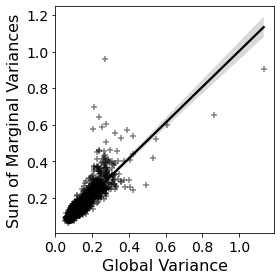

In [4]:
df = pd.read_csv("scg_results/umap_N80_2560_results_totalvar.csv")

df = df[df["n"] > 100]

df["Sum of marginal variances"] = df["Fixed data variance"].values + df["Fixed DR variance"]

plt.figure(figsize=(4,4))
sns.regplot(x="Global variance", 
                y="Sum of marginal variances", 
                data=df, 
                scatter_kws={'alpha':0.5},
                marker="+",
                color='k')
                #robust=True)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("Sum of Marginal Variances", fontsize=16)
plt.xlabel("Global Variance", fontsize=16)
plt.tight_layout()
plt.savefig("figures/Figure2/umap_N80_2560_results_totalvar.png", dpi=500, bbox_inches='tight')
plt.show()

## Figure 2F: Stacked bar plots of marginal variances

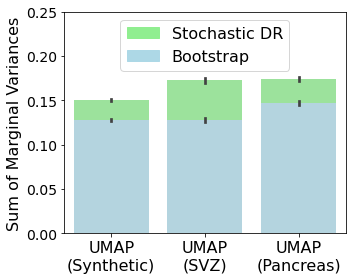

In [3]:
import matplotlib.patches as mpatches

filter_n = 200 # to filter out small n datasets (very noisy)

df_umap5 = pd.read_csv("scg_results/umap_N80_2560_results_totalvar.csv")
df_umap1 = pd.read_csv("scg_results/umap_N80_2560_results_totalvar_onecluster.csv")
df_tsne5 = pd.read_csv("scg_results/tsne_N80_2560_results_totalvar.csv")
df_tsne1 = pd.read_csv("scg_results/tsne_N80_2560_results_totalvar_onecluster.csv")

df_umap_svz = pd.read_csv("scg_results/umap_N80_1000_results_totalvar_svz.csv")
df_tsne_svz = pd.read_csv("scg_results/tsne_N80_1000_results_totalvar_svz.csv")

df_umap_pan = pd.read_csv("scg_results/umap_N80_1000_results_totalvar_pancreas.csv")
df_tsne_pan = pd.read_csv("scg_results/tsne_N80_1000_results_totalvar_pancreas.csv")


x_labels = ["UMAP\n(Synthetic)", "UMAP\n(SVZ)", "UMAP\n(Pancreas)"]#,
           #"t-SNE\n(Syn)", "t-SNE\n(SVZ)", "t-SNE\n(Pan)"]
for di, df in enumerate([df_umap5,df_umap_svz,df_umap_pan]):#,df_tsne5,df_tsne_svz,df_tsne_pan]):
    df["Sum of marginal variances"] = df["Fixed data variance"].values + df["Fixed DR variance"].values
    df["xlabel"] = x_labels[di]
    
df = pd.concat([df_umap5,df_umap_svz,df_umap_pan,df_tsne5,df_tsne_svz,df_tsne_pan], ignore_index=True)
df = df[df["n"] > filter_n].reset_index(drop=True)

plt.figure(figsize=(5,4))
# bar chart 1 -> top bars (group of 'smoker=No')
bar1 = sns.barplot(x="xlabel",  y="Sum of marginal variances", data=df, color='lightgreen')

# bar chart 2 -> bottom bars (group of 'smoker=Yes')
bar2 = sns.barplot(x="xlabel", y="Fixed DR variance", data=df, color='lightblue')

# add legend
top_bar = mpatches.Patch(color='lightgreen', label='Stochastic DR')
bottom_bar = mpatches.Patch(color='lightblue', label='Bootstrap')
plt.legend(handles=[top_bar, bottom_bar], loc='upper center', fontsize=16)
plt.ylim(0,0.25)
bar2.set_xticklabels(bar2.get_xticklabels(),rotation = 0)
bar2.set_ylabel("Sum of Marginal Variances", fontsize=16)
#bar2.set_xlabel("DR method (dataset)", fontsize=16)
bar2.set_xlabel("", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=14)
# show the graph
plt.tight_layout()
plt.savefig("figures/Figure2/stacked_barplot_marginal_variances_withSVZ.png", dpi=500, bbox_inches='tight')
plt.show()

### ED Figure 4F

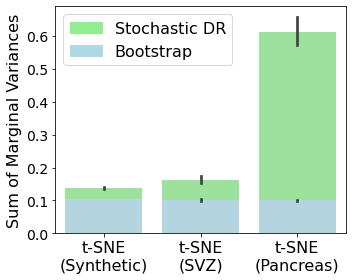

In [3]:
import matplotlib.patches as mpatches

filter_n = 200 # to filter out small n datasets (very noisy)

df_umap5 = pd.read_csv("scg_results/umap_N80_2560_results_totalvar.csv")
df_umap1 = pd.read_csv("scg_results/umap_N80_2560_results_totalvar_onecluster.csv")
df_tsne5 = pd.read_csv("scg_results/tsne_N80_2560_results_totalvar.csv")
df_tsne1 = pd.read_csv("scg_results/tsne_N80_2560_results_totalvar_onecluster.csv")

df_umap_svz = pd.read_csv("scg_results/umap_N80_1000_results_totalvar_svz.csv")
df_tsne_svz = pd.read_csv("scg_results/tsne_N80_1000_results_totalvar_svz.csv")

df_umap_pan = pd.read_csv("scg_results/umap_N80_1000_results_totalvar_pancreas.csv")
df_tsne_pan = pd.read_csv("scg_results/tsne_N80_1000_results_totalvar_pancreas.csv")


x_labels = ["t-SNE\n(Synthetic)", "t-SNE\n(SVZ)", "t-SNE\n(Pancreas)"]
for di, df in enumerate([df_tsne5,df_tsne_svz,df_tsne_pan]):
    df["Sum of marginal variances"] = df["Fixed data variance"].values + df["Fixed DR variance"].values
    df["xlabel"] = x_labels[di]
    
df = pd.concat([df_umap5,df_umap_svz,df_umap_pan,df_tsne5,df_tsne_svz,df_tsne_pan], ignore_index=True)
df = df[df["n"] > filter_n].reset_index(drop=True)

plt.figure(figsize=(5,4))
# bar chart 1 -> top bars (group of 'smoker=No')
bar1 = sns.barplot(x="xlabel",  y="Sum of marginal variances", data=df, color='lightgreen')

# bar chart 2 -> bottom bars (group of 'smoker=Yes')
bar2 = sns.barplot(x="xlabel", y="Fixed DR variance", data=df, color='lightblue')

# add legend
top_bar = mpatches.Patch(color='lightgreen', label='Stochastic DR')
bottom_bar = mpatches.Patch(color='lightblue', label='Bootstrap')
plt.legend(handles=[top_bar, bottom_bar], loc='upper left', fontsize=16)
#plt.ylim(0,0.25)
bar2.set_xticklabels(bar2.get_xticklabels(),rotation = 0)
bar2.set_ylabel("Sum of Marginal Variances", fontsize=16)
#bar2.set_xlabel("DR method (dataset)", fontsize=16)
bar2.set_xlabel("", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=14)
# show the graph
plt.tight_layout()
plt.savefig("figures/Figure2/stacked_barplot_marginal_variances_withSVZ_TSNE.png", dpi=500, bbox_inches='tight')
plt.show()

# Figure 2H: Replicates (clustered data)

### Merfish MOp dataset

In [39]:
adata = sc.read_h5ad("sc_data/mouse_merfish_MOp/counts.h5ad")
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

merfish_metadata = pd.read_csv("sc_data/mouse_merfish_MOp/cell_metadata.csv")

adata.obs = merfish_metadata

In [60]:
np.unique(adata.obs['subclass'])

array(['Astrocytes', 'Endothelial', 'L23_IT', 'L45_IT', 'L56_NP', 'L5_IT',
       'L5_PT', 'L6_CT', 'L6_IT', 'L6_IT_Car3', 'L6b', 'Lamp5',
       'Microglia', 'OPC', 'Oligodendrocytes', 'PVM', 'Pericytes',
       'Pvalb', 'SMC', 'Sncg', 'Sst', 'Sst_Chodl', 'VLMC', 'Vip', 'other'],
      dtype=object)

In [3]:
len(np.unique(adata.obs['subclass']))

25

In [19]:
# Generate all bootstrap reults
base = "outputs/bootstrap/replicates/merfish_3k/"
method = "umap"
nboots = 100
#npcs = 50

for replicate in np.unique(adata.obs['sample_id']):
    
    # subset into replicate
    adata_sub = adata.copy()[adata.obs['sample_id']==replicate]
    if adata_sub.X.shape[0] > 3000:
        sc.pp.subsample(adata_sub, n_obs=3000)
    
    # perform bootstraps
    X, Y = utils.convert_anndata(adata_sub, obs=["subclass"], obsm='none')
    out = boot.generate(X, Y=Y, method=method, B=nboots, use_n_pcs=50, num_jobs=4,
            save=base+str(method)+"_B"+str(nboots)+"_S452_replicate"+str(replicate)+".csv",
            random_seed=452)
    
    # compute variance scores
    variance_scores = score.variance(out, method="random", k=200, X_orig=X, normalize_pairwise_distance=False)
    np.savetxt(base+str(method)+"_B"+str(nboots)+"_S452_replicate"+str(replicate)+"_variance.csv", variance_scores)
    np.savetxt(base+str(method)+"_B"+str(nboots)+"_S452_replicate"+str(replicate)+"_originalX.csv", X)
    Y.to_csv(base+str(method)+"_B"+str(nboots)+"_S452_replicate"+str(replicate)+"_originalY.csv")

100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [03:08<00:00,  1.88s/it]


Setting up neighborhoods...
--- 0.12069892883300781 seconds ---
Populating distances...
--- 430.559730052948 seconds ---
Computing mean pairwise distance for normalization...
--- 14.219855308532715 seconds ---
Computing variance scores...
--- 25.142227172851562 seconds ---


100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [03:05<00:00,  1.85s/it]


Setting up neighborhoods...
--- 0.11025881767272949 seconds ---
Populating distances...
--- 422.7174594402313 seconds ---
Computing mean pairwise distance for normalization...
--- 13.677293539047241 seconds ---
Computing variance scores...
--- 25.347864866256714 seconds ---


100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [03:05<00:00,  1.85s/it]


Setting up neighborhoods...
--- 0.12491583824157715 seconds ---
Populating distances...
--- 411.9478163719177 seconds ---
Computing mean pairwise distance for normalization...
--- 13.198541164398193 seconds ---
Computing variance scores...
--- 25.11116337776184 seconds ---


100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [03:03<00:00,  1.84s/it]


Setting up neighborhoods...
--- 0.11056756973266602 seconds ---
Populating distances...
--- 411.21520709991455 seconds ---
Computing mean pairwise distance for normalization...
--- 12.874357461929321 seconds ---
Computing variance scores...
--- 26.18437671661377 seconds ---


100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [03:06<00:00,  1.87s/it]


Setting up neighborhoods...
--- 0.1156473159790039 seconds ---
Populating distances...
--- 409.3639786243439 seconds ---
Computing mean pairwise distance for normalization...
--- 14.555198669433594 seconds ---
Computing variance scores...
--- 25.0901095867157 seconds ---


100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [03:00<00:00,  1.81s/it]


Setting up neighborhoods...
--- 0.10059738159179688 seconds ---
Populating distances...
--- 417.3416302204132 seconds ---
Computing mean pairwise distance for normalization...
--- 13.687754392623901 seconds ---
Computing variance scores...
--- 25.347193241119385 seconds ---


100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [03:03<00:00,  1.83s/it]


Setting up neighborhoods...
--- 0.10307097434997559 seconds ---
Populating distances...
--- 417.03179931640625 seconds ---
Computing mean pairwise distance for normalization...
--- 13.466764211654663 seconds ---
Computing variance scores...
--- 25.635348558425903 seconds ---


100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [03:02<00:00,  1.83s/it]


Setting up neighborhoods...
--- 0.10298657417297363 seconds ---
Populating distances...
--- 416.674524307251 seconds ---
Computing mean pairwise distance for normalization...
--- 12.96718454360962 seconds ---
Computing variance scores...
--- 24.751147031784058 seconds ---


100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [03:02<00:00,  1.83s/it]


Setting up neighborhoods...
--- 0.11187624931335449 seconds ---
Populating distances...
--- 418.16147685050964 seconds ---
Computing mean pairwise distance for normalization...
--- 13.705258131027222 seconds ---
Computing variance scores...
--- 25.69549322128296 seconds ---


100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [03:01<00:00,  1.81s/it]


Setting up neighborhoods...
--- 0.10217595100402832 seconds ---
Populating distances...
--- 418.81257915496826 seconds ---
Computing mean pairwise distance for normalization...
--- 13.393484115600586 seconds ---
Computing variance scores...
--- 25.12831139564514 seconds ---


100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [03:03<00:00,  1.84s/it]


Setting up neighborhoods...
--- 0.10419821739196777 seconds ---
Populating distances...
--- 417.50015807151794 seconds ---
Computing mean pairwise distance for normalization...
--- 13.241821527481079 seconds ---
Computing variance scores...
--- 26.00374150276184 seconds ---


100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [03:05<00:00,  1.86s/it]


Setting up neighborhoods...
--- 0.1483442783355713 seconds ---
Populating distances...
--- 416.6403419971466 seconds ---
Computing mean pairwise distance for normalization...
--- 13.780950784683228 seconds ---
Computing variance scores...
--- 25.977315425872803 seconds ---


In [20]:
# Generate all bootstrap reults
base = "outputs/bootstrap/replicates/merfish_3k/"
method = "tsne"
nboots = 100
#npcs = 50

for replicate in np.unique(adata.obs['sample_id']):
    
    # subset into replicate
    adata_sub = adata.copy()[adata.obs['sample_id']==replicate]
    if adata_sub.X.shape[0] > 3000:
        sc.pp.subsample(adata_sub, n_obs=3000)
    
    # perform bootstraps
    X, Y = utils.convert_anndata(adata_sub, obs=["subclass"], obsm='none')
    out = boot.generate(X, Y=Y, method=method, B=nboots, use_n_pcs=50, num_jobs=4,
            save=base+str(method)+"_B"+str(nboots)+"_S452_replicate"+str(replicate)+".csv",
            random_seed=452)
        
    # compute variance scores
    variance_scores = score.variance(out, method="random", k=200, X_orig=X, normalize_pairwise_distance=False)
    np.savetxt(base+str(method)+"_B"+str(nboots)+"_S452_replicate"+str(replicate)+"_variance.csv", variance_scores)
    np.savetxt(base+str(method)+"_B"+str(nboots)+"_S452_replicate"+str(replicate)+"_originalX.csv", X)
    Y.to_csv(base+str(method)+"_B"+str(nboots)+"_S452_replicate"+str(replicate)+"_originalY.csv")

100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [04:23<00:00,  2.63s/it]


Setting up neighborhoods...
--- 0.10366201400756836 seconds ---
Populating distances...
--- 421.16333293914795 seconds ---
Computing mean pairwise distance for normalization...
--- 13.416770458221436 seconds ---
Computing variance scores...
--- 26.020289421081543 seconds ---


100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [04:18<00:00,  2.58s/it]


Setting up neighborhoods...
--- 0.1043243408203125 seconds ---
Populating distances...
--- 414.75487327575684 seconds ---
Computing mean pairwise distance for normalization...
--- 13.406521081924438 seconds ---
Computing variance scores...
--- 25.242703676223755 seconds ---


100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [04:16<00:00,  2.56s/it]


Setting up neighborhoods...
--- 0.1056985855102539 seconds ---
Populating distances...
--- 420.0249619483948 seconds ---
Computing mean pairwise distance for normalization...
--- 13.03748869895935 seconds ---
Computing variance scores...
--- 24.870545864105225 seconds ---


100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [04:11<00:00,  2.51s/it]


Setting up neighborhoods...
--- 0.1060326099395752 seconds ---
Populating distances...
--- 420.00918984413147 seconds ---
Computing mean pairwise distance for normalization...
--- 13.212839603424072 seconds ---
Computing variance scores...
--- 24.716168880462646 seconds ---


100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [04:17<00:00,  2.57s/it]


Setting up neighborhoods...
--- 0.1062154769897461 seconds ---
Populating distances...
--- 415.97562623023987 seconds ---
Computing mean pairwise distance for normalization...
--- 13.23650860786438 seconds ---
Computing variance scores...
--- 25.258547067642212 seconds ---


100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [04:18<00:00,  2.59s/it]


Setting up neighborhoods...
--- 0.11348223686218262 seconds ---
Populating distances...
--- 420.49664783477783 seconds ---
Computing mean pairwise distance for normalization...
--- 13.557744979858398 seconds ---
Computing variance scores...
--- 25.12132215499878 seconds ---


100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [04:16<00:00,  2.57s/it]


Setting up neighborhoods...
--- 0.11036181449890137 seconds ---
Populating distances...
--- 417.9982080459595 seconds ---
Computing mean pairwise distance for normalization...
--- 13.469150304794312 seconds ---
Computing variance scores...
--- 26.08849334716797 seconds ---


100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [04:12<00:00,  2.52s/it]


Setting up neighborhoods...
--- 0.1066751480102539 seconds ---
Populating distances...
--- 418.2443025112152 seconds ---
Computing mean pairwise distance for normalization...
--- 13.36272144317627 seconds ---
Computing variance scores...
--- 27.166255235671997 seconds ---


100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [04:20<00:00,  2.60s/it]


Setting up neighborhoods...
--- 0.09953951835632324 seconds ---
Populating distances...
--- 420.3770191669464 seconds ---
Computing mean pairwise distance for normalization...
--- 14.009728193283081 seconds ---
Computing variance scores...
--- 25.33770990371704 seconds ---


100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [04:22<00:00,  2.62s/it]


Setting up neighborhoods...
--- 0.10076713562011719 seconds ---
Populating distances...
--- 420.1564931869507 seconds ---
Computing mean pairwise distance for normalization...
--- 14.247821807861328 seconds ---
Computing variance scores...
--- 25.55712366104126 seconds ---


100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [04:12<00:00,  2.53s/it]


Setting up neighborhoods...
--- 0.10285162925720215 seconds ---
Populating distances...
--- 418.41623163223267 seconds ---
Computing mean pairwise distance for normalization...
--- 12.666975736618042 seconds ---
Computing variance scores...
--- 25.407307863235474 seconds ---


100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [04:10<00:00,  2.50s/it]


Setting up neighborhoods...
--- 0.10756754875183105 seconds ---
Populating distances...
--- 421.0897798538208 seconds ---
Computing mean pairwise distance for normalization...
--- 13.164069414138794 seconds ---
Computing variance scores...
--- 25.850745916366577 seconds ---


### ED Figure 4H

In [21]:
# read data and get celltypes
adata = sc.read_h5ad("sc_data/mouse_merfish_MOp/counts.h5ad")
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

merfish_metadata = pd.read_csv("sc_data/mouse_merfish_MOp/cell_metadata.csv")
adata.obs = merfish_metadata
celltypes = np.unique(adata.obs['subclass'])

In [22]:
# Compute mean gene expression values

method="tsne"
results_path = "outputs/bootstrap/replicates/merfish_3k" # /merfish, /merfish_1k, /merfish_3k
origX_files = [fn for fn in os.listdir(results_path) if (method in fn) and ("originalX" in fn)]

#--------------------------------------------------

mean_gene_expression_variances = []

for ct in celltypes:
    
    mean_ct_gene_expressions = []
    
    for fn in origX_files:

        merfish_X = np.genfromtxt(os.path.join(results_path,fn)) # get full cell x gene matrix
        merfish_y = pd.read_csv(os.path.join(results_path,fn.split("originalX")[0]+"originalY.csv")) # get metadata
        
        try:
            mean_ct_gene_expressions.append(np.nanmean(merfish_X[merfish_y['subclass']==ct, :], axis=0))
        except:
            continue
        
    # compute mean variance across all genes
    ct_gene_variances = np.nanvar(np.array(mean_ct_gene_expressions), axis=0)
    mean_gene_expression_variances.append(np.mean(ct_gene_variances))
    
np.savetxt('merfish_mean_gene_expression_variances_across_replicates.csv', mean_gene_expression_variances)

In [65]:
# compute all concordance scores and read in variance scores for cell types and replicates
method = "tsne"
results_path = "outputs/bootstrap/replicates/merfish_3k" # /merfish, /merfish_1k, /merfish_3k
results_files = [fn for fn in os.listdir(results_path) if (method in fn) and ("variance" not in fn) and ("originalX" not in fn) and ("originalY" not in fn)]

list_score_names = [ 'spearman', 'jaccard', 'mean_projection_error', 'distortion', 'stretch']

#--------------------------------------------------
r_dict = {}

# iterate through each replicate
for replicate_filename in results_files:
    
    # read in file and vscores
    df = pd.read_csv(os.path.join(results_path,replicate_filename))
    df = df[df['bootstrap_number'] == -1]
    vscores = np.genfromtxt(os.path.join(results_path,replicate_filename.split(".")[0]+"_variance.csv"))
    X_orig = np.genfromtxt(os.path.join(results_path,replicate_filename.split(".")[0]+"_originalX.csv"))
    
    # compute concordance scores
    df['variance_score'] = vscores
    for score_type in list_score_names:
        df[score_type] = score.concordance(df, X_orig, method=score_type)
    
    # aggregate by cell type
    scores_dict = {}
    for ct in celltypes:
        for score_type in ['variance_score'] + list_score_names:
            if score_type not in scores_dict.keys():
                scores_dict[score_type] = []
            scores_dict[score_type].append(np.nanmean(df[df['subclass']==ct][score_type]))
        
    # compute correlations with mean gene variance
    for score_type in scores_dict.keys(): 
        if score_type not in r_dict.keys():
            r_dict[score_type] = []
        nas = np.logical_or(np.isnan(mean_gene_expression_variances), np.isnan(scores_dict[score_type]))
        r, p = pearsonr(np.array(mean_gene_expression_variances)[~nas], np.array(scores_dict[score_type])[~nas])
        r_dict[score_type].append(r)
        
# convert dict to dataframe for plotting
r_df = pd.DataFrame.from_dict(r_dict)

# save results
r_df.to_csv("merfish_replicates_"+method+"_r.csv")

In [ ]:
# make plots
r_df = pd.read_csv("merfish_replicates_tsne_r.csv", index_col=0)
rho_df = pd.read_csv("merfish_replicates_tsne_rho.csv", index_col=0)

# make plots
plt.figure(figsize=(8,4))
ax = sns.boxplot(data=r_df, palette=['turquoise','lightgray','lightgray','lightgray','lightgray','lightgray'])
ax = sns.swarmplot(data=r_df, color=".25", size=5)
ax.set_xticklabels(['Variance', 'Spearman', 'Jaccard', 'MPE', 'Distortion', 'Stretch'],rotation = 0)
ax.set_ylabel("MGV Correlation", fontsize=16)
plt.xticks(fontsize=16, rotation=15)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig("figures/Figure2/merfish_tsne_replicates_pearson.png", dpi=500, bbox_inches='tight')
plt.show()

## Figure 2H

In [61]:
# compute all concordance scores and read in variance scores for cell types and replicates
method = "umap"
results_path = "outputs/bootstrap/replicates/merfish_3k" # /merfish, /merfish_1k, /merfish_3k
results_files = [fn for fn in os.listdir(results_path) if (method in fn) and ("variance" not in fn) and ("originalX" not in fn) and ("originalY" not in fn)]

list_score_names = [ 'spearman', 'jaccard', 'mean_projection_error', 'distortion', 'stretch']

#--------------------------------------------------
r_dict = {}

# iterate through each replicate
for replicate_filename in results_files:
    
    # read in file and vscores
    df = pd.read_csv(os.path.join(results_path,replicate_filename))
    df = df[df['bootstrap_number'] == -1]
    vscores = np.genfromtxt(os.path.join(results_path,replicate_filename.split(".")[0]+"_variance.csv"))
    X_orig = np.genfromtxt(os.path.join(results_path,replicate_filename.split(".")[0]+"_originalX.csv"))
    
    # compute concordance scores
    df['variance_score'] = vscores
    for score_type in list_score_names:
        df[score_type] = score.concordance(df, X_orig, method=score_type)
    
    # aggregate by cell type
    scores_dict = {}
    for ct in celltypes:
        for score_type in ['variance_score'] + list_score_names:
            if score_type not in scores_dict.keys():
                scores_dict[score_type] = []
            scores_dict[score_type].append(np.nanmean(df[df['subclass']==ct][score_type]))
        
    # compute correlations with mean gene variance
    for score_type in scores_dict.keys(): 
        if score_type not in r_dict.keys():
            r_dict[score_type] = []
        nas = np.logical_or(np.isnan(mean_gene_expression_variances), np.isnan(scores_dict[score_type]))
        r, p = pearsonr(np.array(mean_gene_expression_variances)[~nas], np.array(scores_dict[score_type])[~nas])
        r_dict[score_type].append(r)
        
# convert dict to dataframe for plotting
r_df = pd.DataFrame.from_dict(r_dict)

# save results
r_df.to_csv("merfish_replicates_"+method+"_r.csv")

In [ ]:
# make plots
r_df = pd.read_csv("merfish_replicates_umap_r.csv", index_col=0)

# make plots
plt.figure(figsize=(8,4))
ax = sns.boxplot(data=r_df, palette=['turquoise','lightgray','lightgray','lightgray','lightgray','lightgray'])
ax = sns.swarmplot(data=r_df, color=".25", size=5)
ax.set_xticklabels(['Variance', 'Spearman', 'Jaccard', 'MPE', 'Distortion', 'Stretch'],rotation = 0)
ax.set_ylabel("MGV Correlation", fontsize=16)
plt.xticks(fontsize=16, rotation=15)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig("figures/Figure2/merfish_umap_replicates_pearson.png", dpi=500, bbox_inches='tight')
plt.show()